In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# data_dir_full = db.query('sess_name=="e15_13f1_220119"')['data_dir_full'][0]
data_dir_full = db.query('sess_name=="e15_13f1_220120"')['data_dir_full'][0]


# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [58]:
pf_res_old = pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=False,force_reload=False, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [59]:
pf_res_new = pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=False,force_reload=False, 
                                        save_fn = 'place_field_afterheadscan.p', 
                                        shuffle_fn='frmap_null_afterheadscan.p',load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/place_field_afterheadscan.p exists; loading---


In [16]:
import fr_map_one_session as fmos

In [17]:
fr_map_res = fmos.main(data_dir_full,load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/fr_map.p exists; loading---


<AxesSubplot:xlabel='lin_binned'>

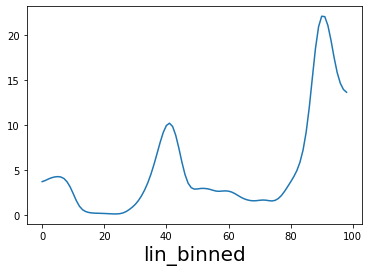

In [22]:
fr_map_res['fr_map'].loc[0,0].loc[42].plot()

In [25]:
fr_map_null = pf.get_fr_map_shuffle_wrapper(data_dir_full,nrepeats=1000, dosave=True,force_reload=False, save_fn='frmap_null_afterheadscan.p')





/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/frmap_null_afterheadscan.p exists; loading---


In [36]:
cell_cols = cell_cols_d['pyr']
fr_map_pf =pf.ratemap_from_spk_beh_df_onetrialtype(spk_beh_df.loc[spk_beh_df['trial_type']==(0,0)],cell_cols,speed_thresh=0.5,bin_size=2.2,nbins=100,smth_in_bin=2.5,speed_key='directed_locomotion')




<AxesSubplot:xlabel='lin_binned'>

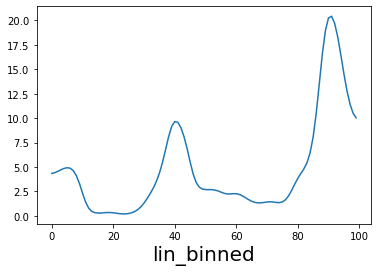

In [39]:
fr_map_pf[0].loc[42].plot()

In [40]:
sbdf = spk_beh_df.loc[spk_beh_df['trial_type']==(0,0)]

In [44]:
i = 1000
speed_thresh = 0.5
nbins=None
smth_in_bin=2.5
bin_size=2.2
speed_key = 'directed_locomotion'

In [53]:
reload(pf)
beh_part=sbdf[['lin',speed_key,'lin_binned','time']] 
spk_df_roll =pd.DataFrame(np.roll(sbdf[cell_cols],i,axis=0),columns=cell_cols,index=sbdf.index)
spk_df_roll = pd.concat([spk_df_roll,beh_part],axis=1)
# fr_map_null_d,_,_ = ratemap_from_spk_beh_df_alltrialtype(spk_df_roll,cell_cols,speed_thresh=speed_thresh,nbins=nbins,smth_in_bin=smth_in_bin)
fr_map_null_one,_,_ = pf.ratemap_from_spk_beh_df_onetrialtype(spk_df_roll,cell_cols,speed_thresh=speed_thresh,nbins=nbins,smth_in_bin=smth_in_bin,bin_size=bin_size,speed_key=speed_key)



<AxesSubplot:xlabel='lin_binned'>

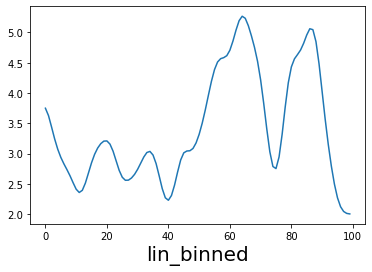

In [57]:
fr_map_null_one.loc[42].plot()

<AxesSubplot:xlabel='lin_binned'>

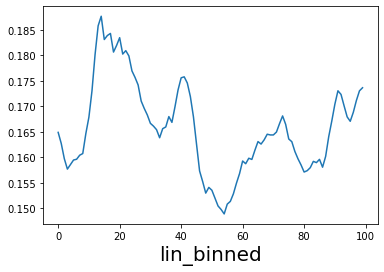

In [54]:
fr_map_null[0,0].loc[(slice(None),42),:].quantile(0.95).plot()

In [65]:

pf_old_inds=pf_res_old['avg']['all_fields'][0,0].index

In [63]:
pf_new_inds=pf_res_new['all_fields'][0,0].index

In [74]:
pf_res_new['all_fields'][0,0].loc[pf_new_inds[[x not in pf_old_inds for x in pf_new_inds]]]

start end com peak    fr_peak   fr_mean
    field_index                                        
47  2              91  99  95   95  10.045215  8.063177
48  1              48  62  54   51    6.93387  6.447065
    2              65  79  72   75   9.711505  8.177472
52  1              77  84  80   81   5.141226  4.705013
57  0               0   5   2    0   5.995312  4.639714
...               ...  ..  ..  ...        ...       ...
284 1              89  97  93   93   1.322879  0.922164
287 2              90  96  93   93   1.024916  0.908821
288 1              16  33  24   26   9.530995  5.925482
    3              83  88  85   86   2.295564  2.092735
289 1              94  99  97   99   4.516293  3.313349

[75 rows x 6 columns]

<AxesSubplot:xlabel='lin_binned'>

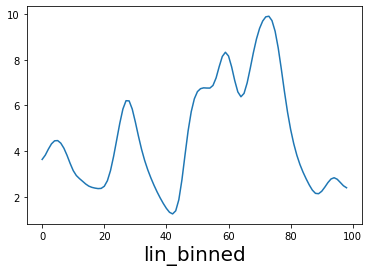

In [81]:
fr_map_res['fr_map'].loc[0,0].loc[48].plot()

In [72]:
pf_res_new['all_fields'][0,0]

start end com peak    fr_peak    fr_mean
    field_index                                         
42  1              36  45  40   40    9.65561   7.829082
    2              83  99  91   91  20.426195  13.764812
43  0               4  30  19   23  10.051708   5.274427
    1              71  77  73   74   2.998244   2.844559
47  1              68  78  73   74   7.488194   6.502278
...               ...  ..  ..  ...        ...        ...
293 0              58  69  63   63   2.896952   1.814461
295 0               0  10   4    3   6.316875    4.82038
297 0              28  49  38   33   3.501972   2.479724
299 1              71  83  76   77   2.027511   1.143457
302 1              86  99  93   93   4.989363   2.689842

[309 rows x 6 columns]